# Sobre árboles de decisión

Comenzaremos revisando algunos conceptos básicos sobre el funcionamiento de los árboles de decisión. A medida que avancemos en las clases, exploraremos sus diversas características y desafíos, con el objetivo de comprender por qué, en problemas de modelado de datos tabulares, siguen siendo el estado del arte, superando incluso a los modelos más complejos de redes neuronales.

Empezaremos con un hermosa visualización de como funcionan gracias a la gente de **R2D3**

[Cómo funciona un árbol de decisión](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)

Y luego empezaremos a trabajar con nuestro conjunto de datos para *tratar* de modelar uno. Para eso, debemos iniciar el entorno

## Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree


Variables importantes

In [3]:
dataset_path = 'C:/Users/pedro/Documents/DMEyF/dmeyf2025/data/'
dataset_file = 'processed/competencia_01.csv'

ganancia_acierto = 780000
costo_estimulo = 20000

Cargamos el **dataset**, vamos a trabajar en esta ocasión solo con un periodo: **202104**.

Algo que va a generar algo de confusión es que no separemos con **Train / Test** en esta ocasión.

**NO ENTRE EN PÁNICO**, en esta cursada se le dedicará mucho tiempo a entender y combatir el problema del overfitting. Pero no hoy.

In [4]:
data = pd.read_csv(dataset_path+dataset_file)
data = data[data['foto_mes'] == 202104]

X = data.drop('clase_ternaria', axis=1)
y = data['clase_ternaria']


Veamos que porcentaje ocupa de nuestro dataset, el target que queremos predecir

In [5]:
data['clase_ternaria'].value_counts(normalize=True)*100

clase_ternaria
CONTINUA    98.724131
BAJA+2       0.692090
BAJA+1       0.583779
Name: proportion, dtype: float64

* **¿Había trabajado con un target tan poco representativo?**
* **¿Cree que esto es algo común o tan solo una rareza?**

## Primer árbol
Con nuestros datos ya cargados en **memoria**, podemos dedicarnos a generar nuestro primer árbol

### Párametros

(gentileza de chat-gpt en un 90%)

El **DecisionTreeClassifier** en scikit-learn tiene varios parámetros que controlan cómo se construye el árbol de decisión. A continuación te explico los más importantes:

1. **criterion**: Este parámetro define la función que se usa para medir la calidad de una división (split). Las opciones principales son:

 * **gini** (predeterminado): Utiliza el índice de Gini, que mide la impureza de las particiones. Un valor de Gini más bajo significa que una partición es más pura.
 * **entropy**: Utiliza la entropía de la información, relacionada con el concepto de ganancia de información. Se enfoca en reducir la incertidumbre en las particiones.

 [Explicación de ambos criterios](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/)

2. **max_depth**: Controla la profundidad máxima del árbol.

3. **min_samples_split**: Especifica el número mínimo de muestras que un nodo debe tener para poder dividirse.

4. **min_samples_leaf**: Define el número mínimo de muestras que debe tener una hoja (nodo final).

5. **max_features**: Indica el número máximo de características que el modelo debe considerar para hacer la mejor división.

6. **max_leaf_nodes**: Especifica el número máximo de nodos hoja que el árbol puede tener.

7. **random_state**: Fija la semilla utilizada por el generador de números aleatorios, lo que garantiza que los resultados del entrenamiento sean reproducibles.

8. **ccp_alpha**: Parámetro de complejidad de poda mínima, utilizado para la poda de árboles de decisión después de que se hayan construido. Un valor más alto lleva a árboles más pequeños.

 **EN LA CURSADA CREEMOS QUE LA INTELIGENCIA DEL ALUMNO CORRELACIONA DE FORMA NEGATIVA A VALOR QUE SETEA ESTE PARÁMETRO**

Queda de tarea para el alumnado jugar con algunas parametrías. Usaremos a continuación una simple

### Modelo

In [6]:
model = DecisionTreeClassifier(criterion='gini',
                               random_state=17,
                               min_samples_split=80,
                               min_samples_leaf=1,
                               max_depth=20)

model.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,20
,min_samples_split,80
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Visualización

Todo es mucho más bonito si tiene colores

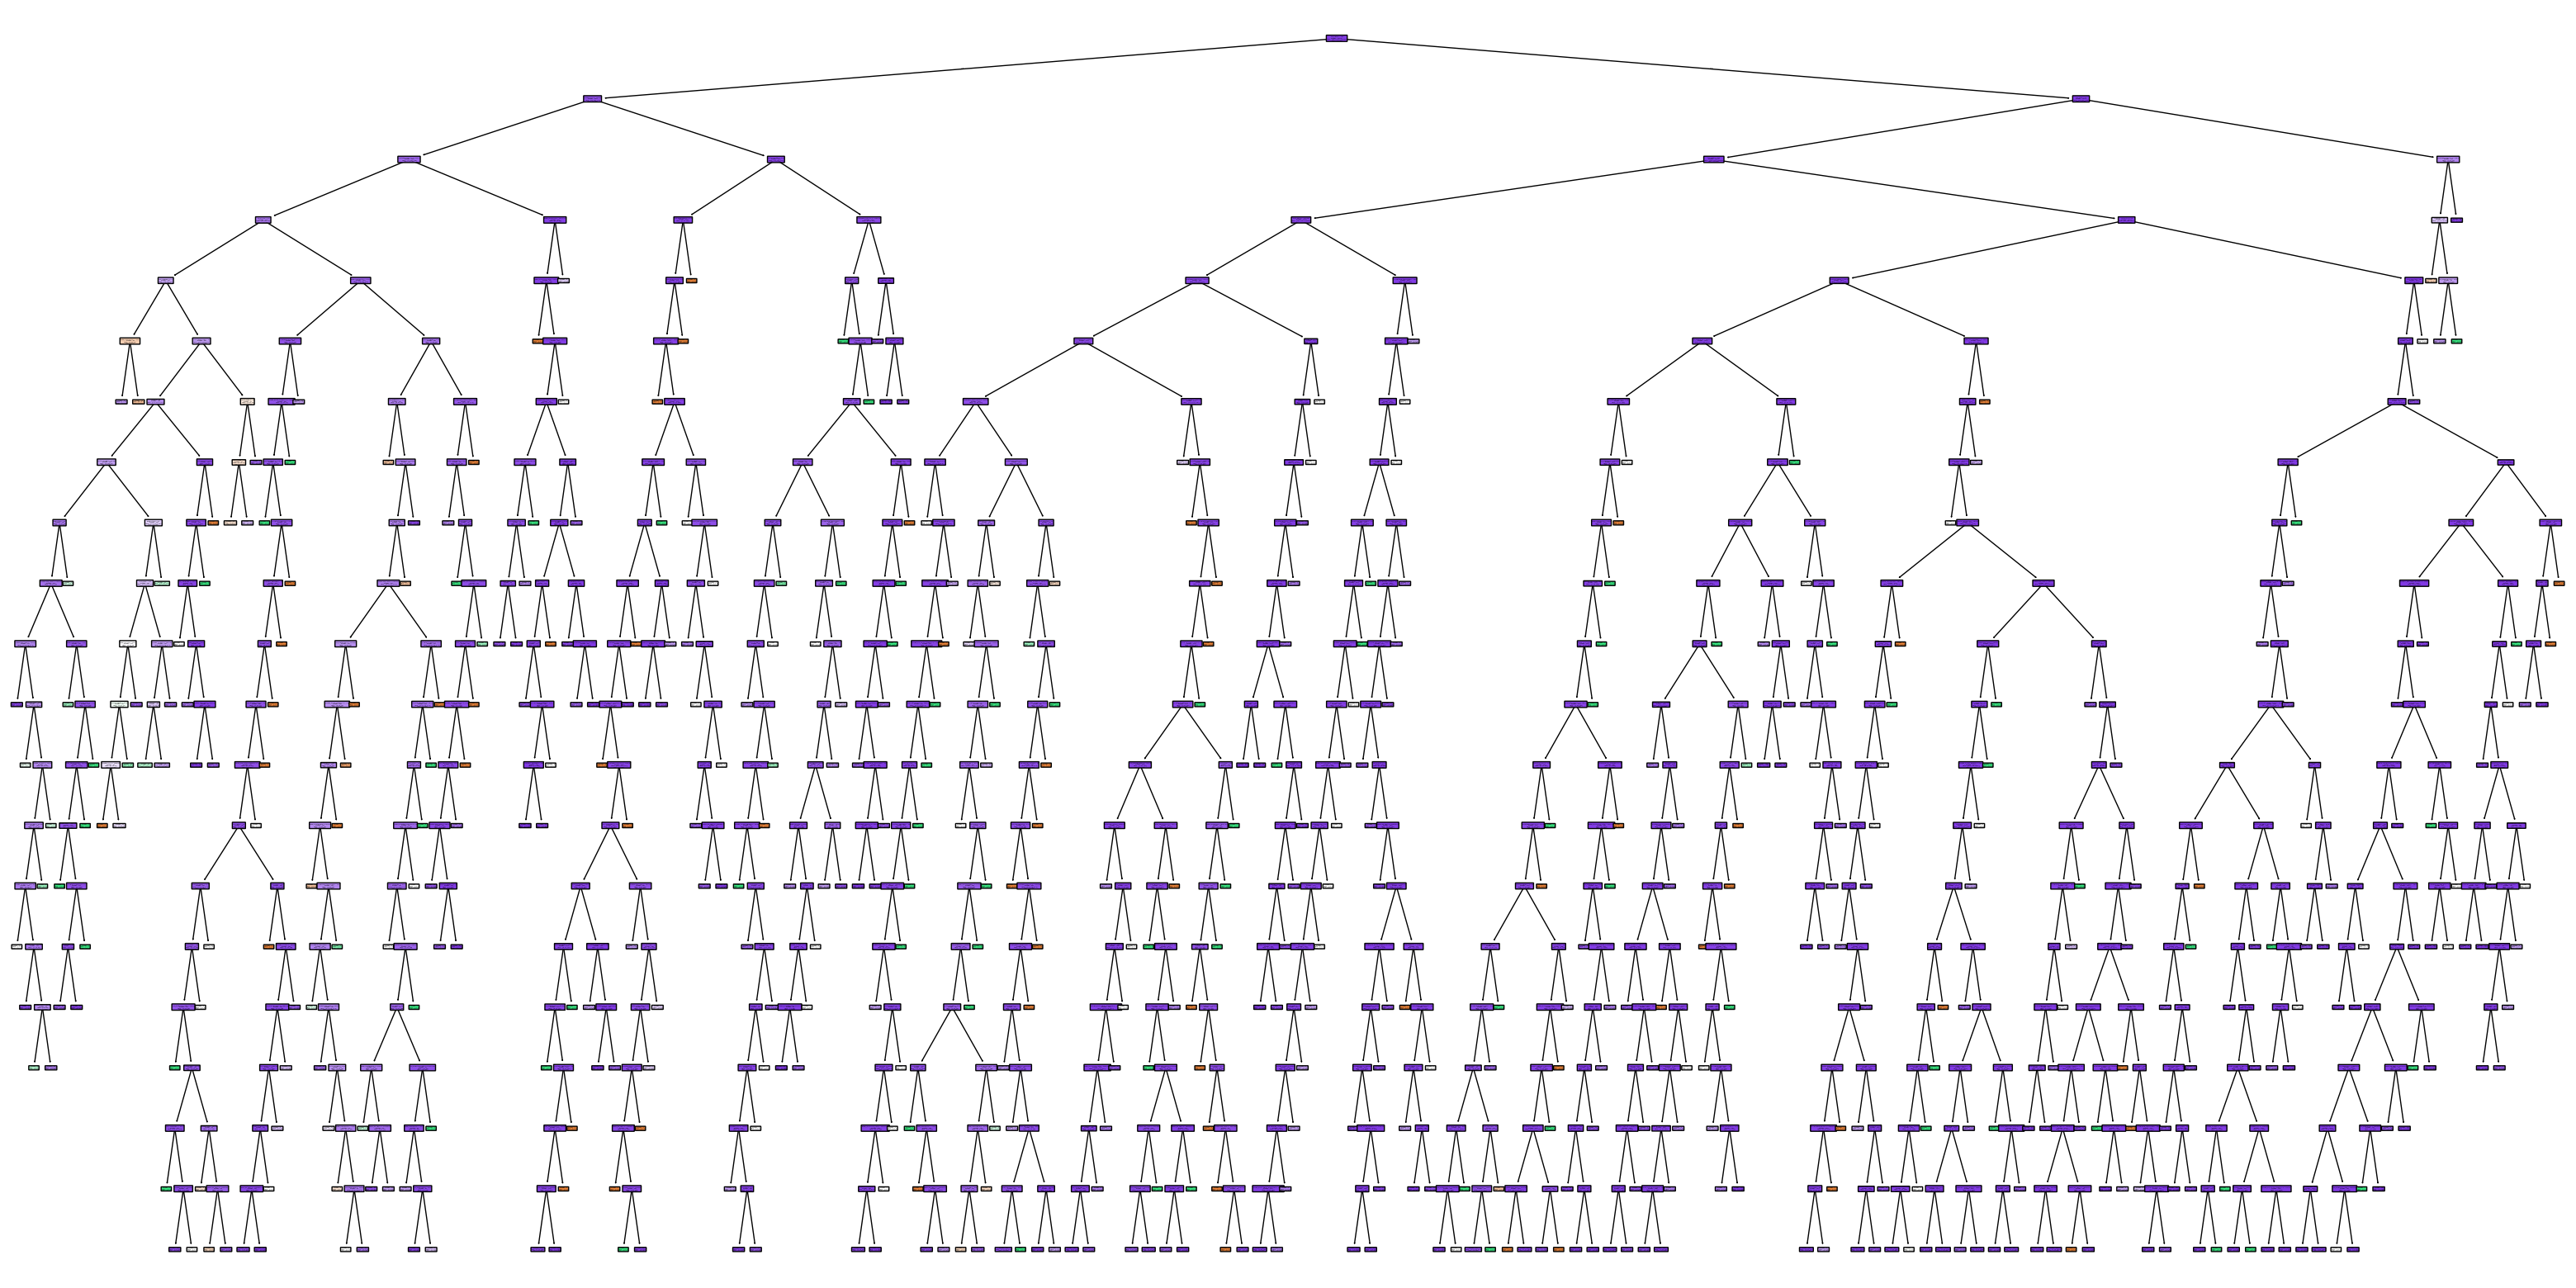

In [7]:
plt.figure(figsize=(40,20))
plot_tree(model, feature_names=X.columns, filled=True, class_names=model.classes_, rounded=True, impurity=False) #,  proportion=True)
plt.show()

### Midiendo el modelo

Mirando tan solo la visualización

* **¿Qué tan bien performó el modelo?**
* **¿Qué tan bien detectó los CONTINUA?**
* **¿Qué tan bien detectó los BAJA+2?**

Para meter manos en la masa, vamos a llevar las hojas del modelo a una tabla, para esto haremos uso de una función auxiliar

In [8]:
def get_leaf_info(tree):
    tree_ = tree.tree_
    class_names = tree.classes_
    leaf_info = []
    for i in range(tree_.node_count):
        if tree_.children_left[i] == _tree.TREE_LEAF:
            class_counts = tree_.value[i][0] * tree_.n_node_samples[i]
            predicted_class_index = class_counts.argmax()
            predicted_class = class_names[predicted_class_index]
            row = {
                'Node': i,
                'Samples': int(tree_.n_node_samples[i]),
                'Predicted Class': predicted_class
            }
            for j, class_name in enumerate(class_names):
                row[class_name] = int(class_counts[j])
            leaf_info.append(row)
    return pd.DataFrame(leaf_info)

leaf_df = get_leaf_info(model)
leaf_df


,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA
0,6,15,CONTINUA,1,4,10
1,7,70,BAJA+1,45,16,9
2,14,24,CONTINUA,1,0,23
3,16,15,BAJA+2,4,6,5
4,20,11,BAJA+1,5,1,5
...,...,...,...,...,...,...
502,1005,2,BAJA+1,1,0,1
503,1008,29,BAJA+1,17,3,9
504,1010,79,CONTINUA,22,5,52
505,1011,3,BAJA+2,0,3,0


Ahora en el dataset **leaf_ds** tenemos cada nodo terminal (hoja).

Vemos que según el modelo, no deberíamos mandar ningún estímulo, dado que no detectó ningún **BAJA+2**. Sin embargo dudaremos de esto y veremos cuanta plata nos hubiera dejado cada hoja, si enviáramos a los clientes que cayeron en esta.


In [9]:
leaf_df["ganancia"] = ganancia_acierto*leaf_df["BAJA+2"] - costo_estimulo*leaf_df["BAJA+1"] + -costo_estimulo*leaf_df["CONTINUA"]
leaf_df.sort_values("ganancia", ascending=False, inplace=True)
leaf_df

,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia
19,48,76,CONTINUA,10,29,37,21680000
25,56,51,BAJA+2,8,28,15,21380000
32,70,68,BAJA+1,33,22,13,16240000
23,54,76,CONTINUA,8,21,47,15280000
20,49,28,BAJA+2,5,18,5,13840000
...,...,...,...,...,...,...,...
391,797,4659,CONTINUA,36,36,4587,-64380000
450,912,6930,CONTINUA,1,2,6927,-137000000
399,810,11439,CONTINUA,13,22,11404,-211180000
419,849,18456,CONTINUA,11,18,18427,-354720000


Vaya! no son pocos las hojas que hubieran dado ganancia positiva, y todas a su vez estuvieron mal clasificadas por el modelo.

Veamos de calcular la probabilidad de **BAJA+2** por cada hoja

In [10]:
leaf_df["prob_baja_2"] = leaf_df["BAJA+2"]/leaf_df["Samples"]
leaf_df.sort_values("prob_baja_2", ascending=False, inplace=True)
leaf_df

,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia,prob_baja_2
395,801,1,BAJA+2,0,1,0,780000,1.0
403,816,1,BAJA+2,0,1,0,780000,1.0
57,119,1,BAJA+2,0,1,0,780000,1.0
318,650,1,BAJA+2,0,1,0,780000,1.0
334,674,1,BAJA+2,0,1,0,780000,1.0
...,...,...,...,...,...,...,...,...
490,990,174,CONTINUA,0,0,174,-3480000,0.0
173,355,190,CONTINUA,0,0,190,-3800000,0.0
467,944,183,CONTINUA,0,0,183,-3660000,0.0
456,921,174,CONTINUA,0,0,174,-3480000,0.0




Finalmente calculemos la ganancia acumulada para cada posible punto de corte:

In [11]:
leaf_df['gan_acumulada'] = leaf_df['ganancia'].cumsum()
leaf_df

,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia,prob_baja_2,gan_acumulada
395,801,1,BAJA+2,0,1,0,780000,1.0,780000
403,816,1,BAJA+2,0,1,0,780000,1.0,1560000
57,119,1,BAJA+2,0,1,0,780000,1.0,2340000
318,650,1,BAJA+2,0,1,0,780000,1.0,3120000
334,674,1,BAJA+2,0,1,0,780000,1.0,3900000
...,...,...,...,...,...,...,...,...,...
490,990,174,CONTINUA,0,0,174,-3480000,0.0,-2346800000
173,355,190,CONTINUA,0,0,190,-3800000,0.0,-2350600000
467,944,183,CONTINUA,0,0,183,-3660000,0.0,-2354260000
456,921,174,CONTINUA,0,0,174,-3480000,0.0,-2357740000


* **¿Cuál es la ganancia máxima que puede obtener con este modelo?**
* **¿Nota alguna relación con la probabilidad de corte óptima discutida en la clase anterior?**


### Matrices de Confusión

Todos ya sabemos que es son las matrices de confusión y como usando los valores de la misma, podemos  [calcular varios estadísticos](https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion)

Una diferencia a lo trabajado hasta ahora en la maestría, es que por cada modelo no vamos a generar 1 matriz de confusión, sino múltiples, 1 por cada punto de corte.

Para eso tenemos que proceder:
* Agrupar los buenos y los malos, ya que la mayoría de los indicadores son binarios
* Calcular los valores: **TP, TN, FP y FN**

In [12]:
leaf_df["evento"] = leaf_df["BAJA+2"]
leaf_df["no_evento"] = leaf_df["CONTINUA"] + leaf_df["BAJA+1"]

leaf_df["evento_acum"] = leaf_df["evento"].cumsum()
leaf_df["no_evento_acum"] = leaf_df["no_evento"].cumsum()

total_evento = leaf_df["evento"].sum()
total_noevento = leaf_df["no_evento"].sum()

leaf_df['evento_restantes'] = total_evento - leaf_df["evento_acum"]
leaf_df['noevento_restantes'] = total_noevento - leaf_df["no_evento_acum"]

leaf_df["TP"] = leaf_df["evento_acum"]
leaf_df["TN"] = leaf_df["noevento_restantes"]
leaf_df["FP"] = leaf_df["no_evento_acum"]
leaf_df["FN"] = leaf_df["evento_restantes"]

leaf_df

,Node,Samples,Predicted Class,BAJA+1,BAJA+2,CONTINUA,ganancia,prob_baja_2,gan_acumulada,evento,no_evento,evento_acum,no_evento_acum,evento_restantes,noevento_restantes,TP,TN,FP,FN
395,801,1,BAJA+2,0,1,0,780000,1.0,780000,1,0,1,0,1130,162287,1,162287,0,1130
403,816,1,BAJA+2,0,1,0,780000,1.0,1560000,1,0,2,0,1129,162287,2,162287,0,1129
57,119,1,BAJA+2,0,1,0,780000,1.0,2340000,1,0,3,0,1128,162287,3,162287,0,1128
318,650,1,BAJA+2,0,1,0,780000,1.0,3120000,1,0,4,0,1127,162287,4,162287,0,1127
334,674,1,BAJA+2,0,1,0,780000,1.0,3900000,1,0,5,0,1126,162287,5,162287,0,1126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,990,174,CONTINUA,0,0,174,-3480000,0.0,-2346800000,0,174,1131,161449,0,838,1131,838,161449,0
173,355,190,CONTINUA,0,0,190,-3800000,0.0,-2350600000,0,190,1131,161639,0,648,1131,648,161639,0
467,944,183,CONTINUA,0,0,183,-3660000,0.0,-2354260000,0,183,1131,161822,0,465,1131,465,161822,0
456,921,174,CONTINUA,0,0,174,-3480000,0.0,-2357740000,0,174,1131,161996,0,291,1131,291,161996,0


Nos quedamos con una tabla reducida

In [13]:
leaf2_df = leaf_df[["prob_baja_2", "TP", "TN", "FP", "FN"]].copy()
leaf2_df.sort_values("prob_baja_2", ascending=False, inplace=True)
leaf2_df

,prob_baja_2,TP,TN,FP,FN
256,1.0,40,162287,0,1091
257,1.0,41,162287,0,1090
195,1.0,19,162287,0,1112
208,1.0,18,162287,0,1113
149,1.0,39,162287,0,1092
...,...,...,...,...,...
490,0.0,1131,838,161449,0
173,0.0,1131,648,161639,0
467,0.0,1131,465,161822,0
456,0.0,1131,291,161996,0


Con esta tabla podemos nos solo calcular los indicadores clásicos, sino que podemos hacer por cada punto de corte, dibujar la curva y establecer cuál es el optimo punto de corte que máximiza el métrica.



#### curva ROC

La curva ROC (Receiver Operating Characteristic) es una herramienta gráfica utilizada en ciencia de datos para evaluar el rendimiento de un modelo de clasificación binaria. Es particularmente útil para entender  el trade-off entre cuánto podemos ganar, en función de cuanto estamos dispuestos a perder.

Se dibuja como **Tasa de Falsos Positivos** contra **Tasa de Verdaderos Positivos**


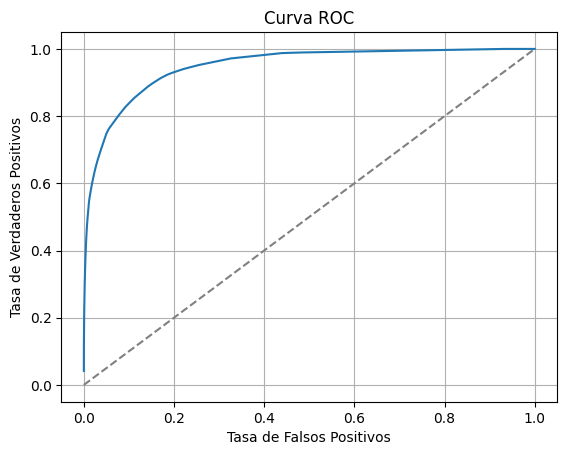

In [14]:
leaf2_df['TPR'] = leaf2_df['TP'] / (leaf2_df['TP'] + leaf2_df['FN'])
leaf2_df['FPR'] = leaf2_df['FP'] / (leaf2_df['FP'] + leaf2_df['TN'])

sns.lineplot(x='FPR', y='TPR', data=leaf2_df)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.grid(True)
plt.show()

# Nota: Es probable que los valores de FPR y TPR esten lejos del [0,0] y [1,1]
# si ese es su caso, debe agregarlos a mano a la tabla

* La línea de identidad indica el comportamiento de un clasificador que no tiene ninguna habilidad para distinguir entre las clases positivas y negativas.
* Es una métrica independiente de la distribución de clases: La curva ROC no depende de la distribución de las clases en los datos (balance de clases), lo que la hace útil en situaciones donde las clases están desbalanceadas.
* Es una evaluación global del modelo: La curva ROC proporciona una visión más completa del rendimiento del modelo.

No todo son rosas, si queremos comparar 2 modelos, mirar curvas puede ser complejo. Por esto mismo, se suele calcular la métrica **AUC** (Area Under the Curve) como un estatístico de la calidad del modelo.

In [15]:
np.trapezoid(leaf2_df['TPR'], leaf2_df['FPR']) # calcula el área de bajo de la curva

np.float64(0.9482669242840824)

* AUC = 1: El modelo clasifica perfectamente todas las instancias. Más cerca de 1 se encuentra el indicador, mejor.
* AUC = 0.5: El modelo no tiene capacidad discriminativa; su rendimiento es equivalente a realizar una clasificación aleatoria.
* AUC < 0.5: Indica un rendimiento peor que una clasificación aleatoria (dale vuelta a la clase).
* Más de una curva puede tener la misma AUC, se suele elegir a la más empinada

### Tarea
* Cambie los parámetros del modelo y vea los impactos en cada una de las métricas.
 * ¿Cuál fue el modelo que dió más ganancia económica? ¿El peor?
 * ¿Cuál fue el modelo que dió mayor AUC? ¿El peor?
* Calcule, dibuje y encuentre el punto de corte óptimo para:
 * Accuracy
 * Sensibilidad
 * Especificidad
 * F1-Score

## Explorando el dataset

En esta última parte, vamos a realizar un **EDA** rápido del dataset.



### Sumarizando

Empezamos por un pantallazo sobre todas las variables, con una **sumarización**, agregando 2 estadísticos muy importantes que no trae por defecto **Pandas**

* **Número de valores únicos de una variables**: Muchas veces variables categóricas están codificadas en variables numéricas. Este indicador nos ayudará a detectarlas
* **Número de missing values**: Que cantidad de registros tienen valores numéricos y cuales tiene faltantes. El tratamiento (o no) de missings es uno de los temas que navegarán en los **experimentos colectivos**

Navegue la tabla a la par de el **diccionario de datos**. Los alumnos tienen a subestimar el poder de entender el conjunto de datos a la hora de hacer un buen modelo.

In [16]:
desc_stats = data.describe(include='all') # Calcula estadísticas descriptivas básicas
missing_values = data.isnull().sum() # Calcula el número de valores faltantes por columna
unique_values = data.nunique() # Calcula el número de valores distintos por columna

# Combina las estadísticas en un solo DataFrame
summary_table = pd.DataFrame({
    'Missing Values': missing_values,
    'Unique Values': unique_values
})

pd.concat([summary_table.transpose(), desc_stats], axis=0).transpose()


,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
numero_de_cliente,0.0,163418.0,163418.0,NaN,NaN,NaN,772035043.339516,323173165.552037,249221323.0,518848832.5,733719566.0,1000958823.0,1592903498.0
foto_mes,0.0,1.0,163418.0,NaN,NaN,NaN,202104.0,0.0,202104.0,202104.0,202104.0,202104.0,202104.0
active_quarter,0.0,2.0,163418.0,NaN,NaN,NaN,0.987351,0.111753,0.0,1.0,1.0,1.0,1.0
cliente_vip,0.0,2.0,163418.0,NaN,NaN,NaN,0.002338,0.048292,0.0,0.0,0.0,0.0,1.0
internet,0.0,5.0,163418.0,NaN,NaN,NaN,0.062686,0.314405,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Visa_mconsumototal,21744.0,115634.0,141674.0,NaN,NaN,NaN,21975.942632,39935.503302,-43266.18,2285.055,9756.635,26406.555,1923843.72
Visa_cconsumos,21744.0,127.0,141674.0,NaN,NaN,NaN,8.121568,9.776295,0.0,2.0,5.0,11.0,208.0
Visa_cadelantosefectivo,21744.0,12.0,141674.0,NaN,NaN,NaN,0.008661,0.195276,0.0,0.0,0.0,0.0,14.0
Visa_mpagominimo,7918.0,5678.0,155500.0,NaN,NaN,NaN,6155.158392,21954.770202,0.0,598.23,2240.43,5630.4,3814220.64


### Explorando las variables más importantes del modelo

Vamos a profundizar sobre las variables utilizadas por el modelo. Si las eligió el modelo, seguro nos ayudará a entender un poco más los datos, no?

Para este fin, vamos a obtener la importancia de variable del modelo

In [17]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False)


,feature,importance
107,ctrx_quarter,0.131964
33,mprestamos_personales,0.081781
22,mcuentas_saldo,0.080881
26,ctarjeta_visa,0.043096
11,mpasivos_margen,0.033078
...,...,...
129,Master_cconsumos,0.000000
130,Master_cadelantosefectivo,0.000000
143,Visa_madelantopesos,0.000000
144,Visa_madelantodolares,0.000000


Tomaremos algunas para hacer un doble click

#### ctrx_quarter

**¿Qué significa esta variable?**

Cómo se trata de una variable numéricas, vamos a graficar la densidad por cada clase:

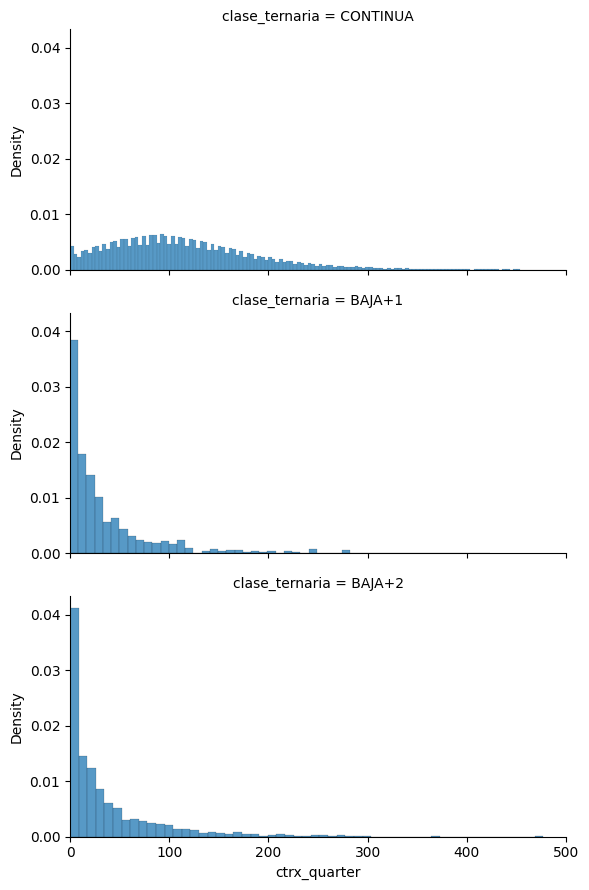

In [18]:
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "ctrx_quarter", stat='density')
g.set(xlim = (0, 500))

* **¿Qué conclusiones saca de los gráficos?**
* **¿Detecta algún patrón en la baja de los clientes?**

#### Visa_status

**¿Qué significa esta variable?**

Esta variable es númerica, pero tiene una baja cardinalidad. Vamos a estudiarla de otra manera

In [127]:
pd.crosstab(data['Visa_status'], data['clase_ternaria'])

clase_ternaria,BAJA+1,BAJA+2,CONTINUA
Visa_status,,,
0.0,658,789,153449
6.0,7,2,4
7.0,32,11,293
9.0,68,30,157


* **¿Qué conclusiones saca de esta tabla?**
* **¿Detecta algún patrón en la baja de los clientes?**
* **¿Puede generar una regla a mano que le haga ganar plata al banco?** si es así, ¿Cuánta plata ganaría?

#### mpasivos_margen

**¿Qué significa esta variable?**

Esta variable también es númerica. Intente gráficar un diagrama de densidad y verá que no es algo que vaya a funcionar muy bien.

Frente a un escenario así podemos recurrir a los todo poderosos **box-plots**

<Axes: xlabel='clase_ternaria', ylabel='mrentabilidad_annual'>

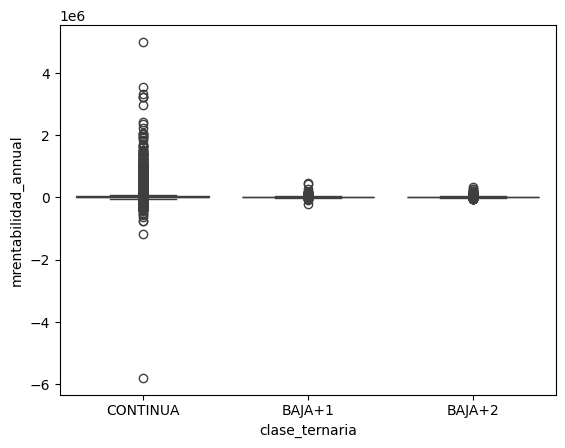

In [20]:
sns.boxplot(x='clase_ternaria', y='mrentabilidad_annual', data=data)

Ok... esto no es muy ilustrativo.

* **¿Qué son esos círculitos?**

Probemos podar un poco la variable:

<Axes: xlabel='clase_ternaria', ylabel='mpasivos_margen'>

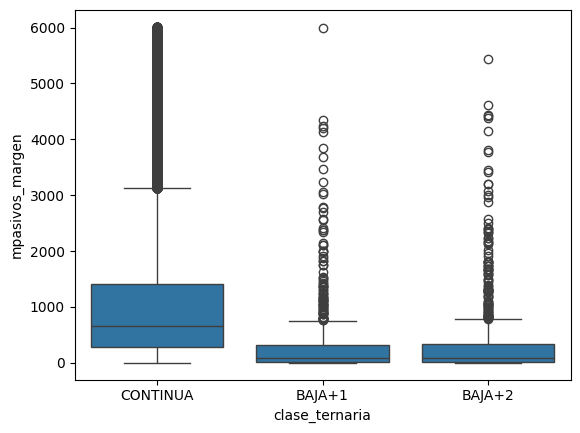

In [129]:
lower_bound = data['mpasivos_margen'].quantile(0.05)
upper_bound = data['mpasivos_margen'].quantile(0.95)

filtered_data = data[(data['mpasivos_margen'] >= lower_bound) & (data['mpasivos_margen'] <= upper_bound)]
sns.boxplot(x='clase_ternaria', y='mpasivos_margen', data=filtered_data)

* **¿Qué paso en el código anterior?**
* **¿Qué interpretación hace sobre el gráfico?**

### Tarea
Esto es solo el comienzo. Tiene que hacer un video a **Miranda** y para eso debe entender bien los datos. Continue con el **EDA**.

* Sume al análisis los periodos descartados
* ¿Se pueden construir features que den más luz a los modelos a detectar las futuras bajas?

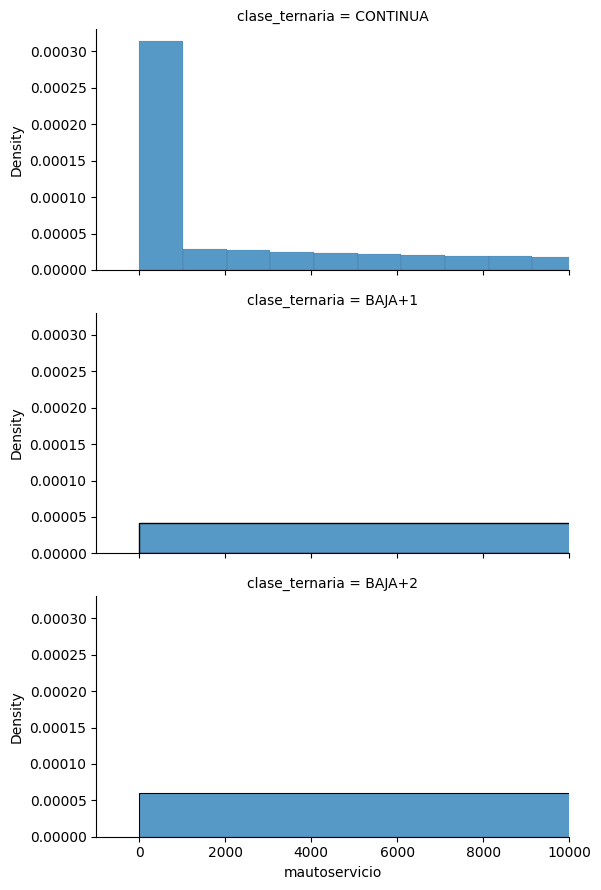

In [35]:
g = sns.FacetGrid(data, row="clase_ternaria", height=3, aspect=2)
g.map(sns.histplot, "mautoservicio", stat='density')
g.set(xlim = (-1000,10000))